# Evaluating the Impact of a New Recommendation System on User Conversion Rates

We will analyze the results of an A/B test conducted by an international online store to evaluate the impact of a new recommendation system on user conversion rates. The A/B test compares the existing payment funnel (control group A) with a new payment funnel integrated with the improved recommendation system (test group B).

# Table of Contents

- [Description of the data](#description) <br>
- [Data Preprocessing](#preprocessing) <br>
    - [Analysing Datasets](#analysis) <br>
    - [Fixing Datasets](#fixing) <br>
    - [Merging Tables](#merging) <br> 
- [Exploratory Data Analysis (EDA)](#EDA) <br>
- [Event Funnel Study](#funnel) <br>
- [Pre-Test Evaluation](#Evaluation) <br>
- [A/B Test Analysis](#AB) <br>
- [Conclusions and Recommendations](#conrec)

## Description of the Data 
<div id='description' ></div>

The analysis utilizes the following datasets:

ab_project_marketing_events_us.csv: Calendar of marketing events for 2020<br>
Columns: 
- name — the name of the marketing event 
- regions — regions where the ad campaign will be held
- start_dt — campaign start date
- finish_dt — campaign end date

final_ab_new_users_upd_us.csv: New users who signed up between December 7 and 21, 2020<br>
Columns: 
- user_id
- first_date — sign-up date
- region
- device — device used to sign up

final_ab_events_upd_us.csv: Events of new users from December 7, 2020, to January 1, 2021<br>
Columns: 
- user_id
- event_dt — event date and time
- event_name — event type name
- details — additional data on the event (for instance, the order total in USD for purchase events)

final_ab_participants_upd_us.csv: Details of test participants<br>
Columns: 
- user_id
- ab_test — test name
- group — the test group the user belonged to

In [1]:
#importing libraries  
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import chi2_contingency
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
from scipy.stats import ttest_ind

In [2]:
#importing data
try:
    events = pd.read_csv('C:/Users/Wandile/Documents/PracticumProjects/ABTestProject/ab_project_marketing_events_us.csv')
    new_users = pd.read_csv('C:/Users/Wandile/Documents/PracticumProjects/ABTestProject/final_ab_new_users_upd_us.csv')
    events_new_users = pd.read_csv('C:/Users/Wandile/Documents/PracticumProjects/ABTestProject/final_ab_events_upd_us.csv')
    participants = pd.read_csv('C:/Users/Wandile/Documents/PracticumProjects/ABTestProject/final_ab_participants_upd_us.csv')
except:
    events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
    events_new_users = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

## Data Preprocessing 
<div id='preprocessing'></div>

### Analysing Datasets
<div id='analysis'></div>

In [3]:
#inspecting events table 
events.info()
print(f'Missing values in events table: {events.isna().sum()}')
print(f'Duplicated values in events table: {events.duplicated().sum()}')
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
Missing values in events table: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Duplicated values in events table: 0


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Comment: The start_dt and finish_dt column should be changed from string type to datetime data type. There are no missing or duplicated values in events table.

In [4]:
#inspecting new_users table
new_users.info()
print(f'Missing values in events table: {new_users.isna().sum()}')
print(f'Duplicated values in events table: {new_users.duplicated().sum()}')
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
Missing values in events table: user_id       0
first_date    0
region        0
device        0
dtype: int64
Duplicated values in events table: 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Comment: The first_date column should be changed from string type to datetime data type. There are no missing or duplicated values in new users table.

In [5]:
#inspecting events new users table
events_new_users.info()
print(f'Missing values in events table: {events_new_users.isna().sum()}')
print(f'Duplicated values in events table: {events_new_users.duplicated().sum()}')
events_new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
Missing values in events table: user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
Duplicated values in events table: 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Comment: The event_dt column should be changed from string type to datetime data type. There are no duplicated values in the events new users table. There are missing values in the details column

In [6]:
# inspecting participants table
participants.info()
print(f'Missing values in events table: {participants.isna().sum()}')
print(f'Duplicated values in events table: {participants.duplicated().sum()}')
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
Missing values in events table: user_id    0
group      0
ab_test    0
dtype: int64
Duplicated values in events table: 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [7]:
#seperating groups
group_A = participants[participants['group']=='A']
group_B = participants[participants['group']=='B']

In [8]:
#joining group A and B data on user_id
pd.merge(group_A,group_B, on='user_id')

,user_id,group_x,ab_test_x,group_y,ab_test_y
0,FC3F3E4DA7C85F88,A,recommender_system_test,B,interface_eu_test
1,FE2AF0E94DBD470E,A,recommender_system_test,B,interface_eu_test
2,C5AD06762E628169,A,recommender_system_test,B,interface_eu_test
3,25CE0629AC6B6971,A,recommender_system_test,B,interface_eu_test
4,44EB15AD423DC31C,A,recommender_system_test,B,interface_eu_test
...,...,...,...,...,...
436,EF449601C94D2496,A,interface_eu_test,B,recommender_system_test
437,59D9BD2A3172D3F4,A,interface_eu_test,B,recommender_system_test
438,13FBEB715F4AAE10,A,interface_eu_test,B,recommender_system_test
439,3DEA2F9B3EDA8B91,A,interface_eu_test,B,recommender_system_test


In [9]:
#dropping users that are in groups A and B
participants = participants.drop_duplicates(subset='user_id')
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


Comment: There are no missing values in the participants table. There were 441 users that appeared in group A and B. These users were removed from the participants table.

### Fixing Datasets
<div id='fixing'></div>

In [10]:
#changing start_dt and finish_dt column to datetime datatype for events table
events['start_dt'] = pd.to_datetime(events['start_dt'], format='%Y-%m-%d')
events['finish_dt'] = pd.to_datetime(events['finish_dt'], format='%Y-%m-%d')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [11]:
#changing first_date column to datetime datatype for new_users table
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [12]:
#changing event_dt column to datetime datatype for events_new_users table
events_new_users['event_dt'] = pd.to_datetime(events_new_users['event_dt'], format='%Y-%m-%d %H:%M:%S')
events_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [13]:
#investigating missing values in the details column in events_new_users table
events_new_users[events_new_users['details'].isna()]

,user_id,event_dt,event_name,details
60314,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
60315,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
60316,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
60317,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
60318,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [14]:
#checking unique values in event_name column
events_new_users['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [15]:
#checking purchase event names
events_new_users[events_new_users['event_name']=='purchase']

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
60309,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
60310,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
60311,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
60312,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


In [16]:
#creating date column for events_new_users table 
events_new_users['date'] = pd.to_datetime(events_new_users['event_dt']).dt.date
events_new_users['date'] = pd.to_datetime(events_new_users['date'],format='%Y-%m-%d')
events_new_users

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07
...,...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-30
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-30
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-30
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-30


Comment: The missing values in the events_new_users are the events new users have participated in other than purchasing. The new users that have purchased has events totaling 60314. This verifies the purchase event users. Therefore missing values in the events can be ignored in the events new users table.

###  Merging Tables
<div id='merging'></div>

In [17]:
#merging new_users table and events_new_users on user_id
events_new_usersmerge = events_new_users.merge(new_users, on='user_id')
events_new_usersmerge

,user_id,event_dt,event_name,details,date,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-07,N.America,iPhone
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-09,2020-12-07,N.America,iPhone
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN,2020-12-07,2020-12-07,N.America,iPhone
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,NaN,2020-12-09,2020-12-07,N.America,iPhone
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,EU,iPhone
...,...,...,...,...,...,...,...,...
423756,C9F1399FDCD83F13,2020-12-24 04:47:08,login,NaN,2020-12-24,2020-12-23,EU,iPhone
423757,C9F1399FDCD83F13,2020-12-27 09:47:46,login,NaN,2020-12-27,2020-12-23,EU,iPhone
423758,4F32B58E4FF19DC5,2020-12-23 20:01:29,login,NaN,2020-12-23,2020-12-23,EU,Android
423759,27767D4BECDD260E,2020-12-26 19:02:18,login,NaN,2020-12-26,2020-12-07,EU,iPhone


In [18]:
#merging events_new_usersmerge with participants table
complete_merge = events_new_usersmerge.merge(participants, on='user_id')
complete_merge.rename(columns={'details':'revenue'},inplace=True)
complete_merge

,user_id,event_dt,event_name,revenue,date,first_date,region,device,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,EU,iPhone,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,2020-12-07,EU,iPhone,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,2020-12-07,EU,iPhone,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,2020-12-07,EU,iPhone,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...,...
97118,40076B77CFC12421,2020-12-23 03:43:28,login,NaN,2020-12-23,2020-12-23,EU,iPhone,B,interface_eu_test
97119,40076B77CFC12421,2020-12-24 04:21:53,login,NaN,2020-12-24,2020-12-23,EU,iPhone,B,interface_eu_test
97120,40076B77CFC12421,2020-12-26 03:50:17,login,NaN,2020-12-26,2020-12-23,EU,iPhone,B,interface_eu_test
97121,301C602AF78BABAD,2020-12-23 10:39:25,login,NaN,2020-12-23,2020-12-23,EU,Android,B,interface_eu_test


Comment: The events_new_users table has 423 761 rows. After the merge with the new_users table the formulated table (events_new_usersmerge) maintained the same number of rows of 423 761. Merging the events_new_usermerge table with the participants table reduced the number of rows to 97 123.

## Exploratory Data Analysis (EDA)
<div id='EDA'></div> <br>

How many events are there in the dataset?

In [19]:
print(f"There are a total of {complete_merge['event_name'].count()} events in the comeplete_merge table and {len(complete_merge['event_name'].unique())} different unique events in the complete_merge table.")

There are a total of 97123 events in the comeplete_merge table and 4 different unique events in the complete_merge table.


How many users are in the dataset?

In [20]:
print(f"There are {len(complete_merge['user_id'].unique())} users in the complete_merge table the same as participants table {len(participants['user_id'].unique())}.")

There are 13638 users in the complete_merge table the same as participants table 13638.


Are there users in both group A and B?

In [21]:
complete_merge[(complete_merge['group']=='A') & (complete_merge['group']=='B')]

,user_id,event_dt,event_name,revenue,date,first_date,region,device,group,ab_test


What's the average number of events per user?

In [22]:
avg_events =  complete_merge['event_name'].count()/len(complete_merge['user_id'].unique())
print(f'The average number of events per user is {avg_events}')

The average number of events per user is 7.121498753482915


What period does the dataset cover?

In [23]:
#finding the maximum and minimum date
mindate = complete_merge['date'].min()
maxdate = complete_merge['date'].max()
print(f"Minimum date {mindate} and maximum date {maxdate}.")

Minimum date 2020-12-07 00:00:00 and maximum date 2020-12-30 00:00:00.


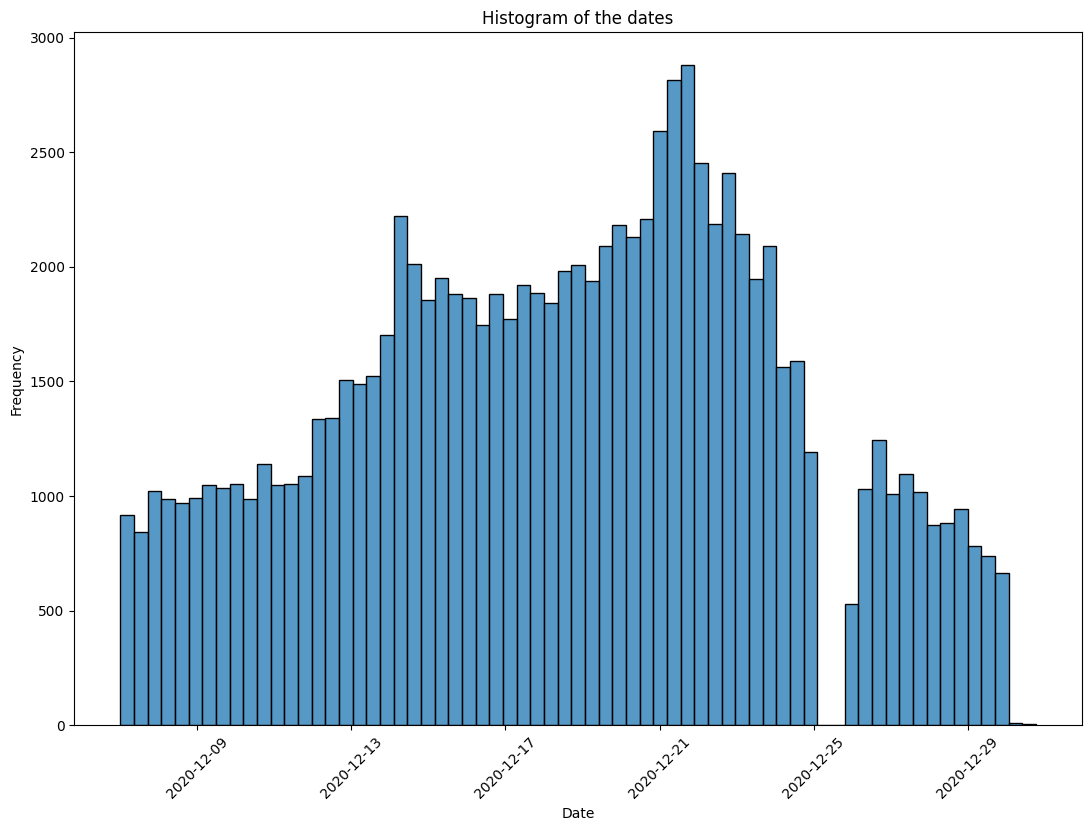

In [24]:
#plotting histogram by the date and time
plt.figure(figsize=(13,9))
sns.histplot(complete_merge['event_dt'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Histogram of the dates')
plt.show()

Comment: The distrubution appears to be a normal one that is slighlty left skewed.

Counting user events in group A and B.

In [25]:
#grouping the A and B groups and creating a total row to count all the records
grouped = complete_merge.groupby('group').agg({'event_name':'count'})
total_row = pd.DataFrame({'event_name':[grouped['event_name'].sum()]}, index=['Total'])
complete = pd.concat([grouped,total_row])
complete

,event_name
A,55762
B,41361
Total,97123


## Event Funnel Study
<div id='funnel'></div> <br>

Determining events and their frequency.

In [26]:
#funnel of entire complete_merge table
event_count = complete_merge.groupby('event_name').agg({'event_name':'count'})
event_count.rename(columns = {'event_name':'frequency'},inplace=True)
event_count = event_count.sort_values(by='frequency',ascending=False).reset_index()
event_count

,event_name,frequency
0,login,42101
1,product_page,27373
2,purchase,14034
3,product_cart,13615


In [27]:
#funnel of group A events
event_countA = complete_merge[complete_merge['group']=='A'].groupby('event_name').agg({'event_name':'count'})
event_countA.rename(columns = {'event_name':'event','event_name':'frequency'},inplace=True)
event_countA = event_countA.sort_values(by='frequency',ascending=False).reset_index()
event_countA

,event_name,frequency
0,login,24043
1,product_page,15872
2,purchase,8176
3,product_cart,7671


In [28]:
#funnel of group B events
event_countB = complete_merge[complete_merge['group']=='B'].groupby('event_name').agg({'event_name':'count'})
event_countB.rename(columns = {'event_name':'event','event_name':'frequency'},inplace=True)
event_countB = event_countB.sort_values(by='frequency',ascending=False).reset_index()
event_countB

,event_name,frequency
0,login,18058
1,product_page,11501
2,product_cart,5944
3,purchase,5858


Finding number of users who performed each event.

In [29]:
#unique user event count for enetire complete merge table
user_event =  complete_merge.groupby('event_name').agg({'user_id':'nunique'})
user_event.rename(columns={'user_id':'unique_users'},inplace=True)
user_event.sort_values(by='unique_users',ascending=False).reset_index()

,event_name,unique_users
0,login,13636
1,product_page,8923
2,purchase,4563
3,product_cart,4394


In [30]:
#unique user event count for group A
user_eventA =  complete_merge[complete_merge['group']=='A'].groupby('event_name').agg({'user_id':'nunique'})
user_eventA.rename(columns={'user_id':'unique_users'},inplace=True)
user_eventA.sort_values(by='unique_users',ascending=False).reset_index()

,event_name,unique_users
0,login,7757
1,product_page,5146
2,purchase,2654
3,product_cart,2453


In [31]:
#unique user event count for group B 
user_eventB =  complete_merge[complete_merge['group']=='B'].groupby('event_name').agg({'user_id':'nunique'})
user_eventB.rename(columns={'user_id':'unique_users'},inplace=True)
user_eventB.sort_values(by='unique_users',ascending=False).reset_index()

,event_name,unique_users
0,login,5879
1,product_page,3777
2,product_cart,1941
3,purchase,1909


Calculating the proportion of users that performed an event at least once

In [32]:
#Calculating the proportion of combined complete_merge table, merging event_count and user_event table
proportion = pd.merge(event_count,user_event,on='event_name')
proportion['proportion'] = proportion['unique_users']/proportion['frequency']
proportion.sort_values(by='proportion', ascending=False)

,event_name,frequency,unique_users,proportion
1,product_page,27373,8923,0.325978
2,purchase,14034,4563,0.325139
0,login,42101,13636,0.323888
3,product_cart,13615,4394,0.322732


In [33]:
#Calculating the proportion of group A 
proportionA = pd.merge(event_countA,user_eventA,on='event_name')
proportionA['proportion'] = proportionA['unique_users']/proportionA['frequency']
proportionA.sort_values(by='proportion', ascending=False)

,event_name,frequency,unique_users,proportion
2,purchase,8176,2654,0.324609
1,product_page,15872,5146,0.324219
0,login,24043,7757,0.322630
3,product_cart,7671,2453,0.319776


In [34]:
#Calculating the proportion of group B
proportionB = pd.merge(event_countB,user_eventB,on='event_name')
proportionB['proportion'] = proportionB['unique_users']/proportionB['frequency']
proportionB.sort_values(by='proportion', ascending=False)

,event_name,frequency,unique_users,proportion
1,product_page,11501,3777,0.328406
2,product_cart,5944,1941,0.326548
3,purchase,5858,1909,0.325879
0,login,18058,5879,0.325562


Finding share of users that proceed from one event to the next.

In [35]:
#conversion for complete_merge table
user_event['total conversion (%)'] = ((user_event['unique_users']/user_event['unique_users'].max())*100).round()
user_event.sort_values(by='unique_users', ascending=False)

,unique_users,total conversion (%)
event_name,,
login,13636,100.0
product_page,8923,65.0
purchase,4563,33.0
product_cart,4394,32.0


In [36]:
#conversion for group A
user_eventA['total conversion (%)'] = ((user_eventA['unique_users']/user_eventA['unique_users'].max())*100).round()
user_eventA.sort_values(by='unique_users', ascending=False)

,unique_users,total conversion (%)
event_name,,
login,7757,100.0
product_page,5146,66.0
purchase,2654,34.0
product_cart,2453,32.0


In [37]:
#conversion for group B
user_eventB['total conversion (%)'] = ((user_eventB['unique_users']/user_eventB['unique_users'].max())*100).round()
user_eventB.sort_values(by='unique_users', ascending=False)

,unique_users,total conversion (%)
event_name,,
login,5879,100.0
product_page,3777,64.0
product_cart,1941,33.0
purchase,1909,32.0


What share of the users go through all the events.

In [38]:
#filtering users with all the events
all_events_users = complete_merge.groupby('user_id').agg({'event_name':'nunique'})
all_events_users.rename(columns={'event_name':'number_of_events'},inplace=True)
all_events_users.reset_index()
all_events_users = all_events_users[all_events_users['number_of_events']==4]
#calculating share of users that are in all events
share = (len(all_events_users)/len(complete_merge['user_id'].unique()))*100
print(f"The share of users that make it through all the events is {share}% of the users.")

The share of users that make it through all the events is 7.134477196069805% of the users.


Comment: For the entire complete_merge table and group A the product cart is less than the purchase event. For group B the purchase event is less than the product cart event. This trend is observed for the frequency of events, the number of unique users, the proportions and the converstion. The proportions for all three groups lies at 30% however the orders are different.

## Pre-Test Evaluation
<div id='Evaluation'></div> <br>

How many users are there in each group?

In [39]:
grouped =  complete_merge.groupby('group').agg({'user_id':'nunique'})
total_row = pd.DataFrame({'user_id':[grouped['user_id'].sum()]}, index=['Total'])
completeg = pd.concat([grouped,total_row])
completeg

,user_id
A,7758
B,5880
Total,13638


In [40]:
#getting users performing the events
users_per_event = complete_merge.groupby(['group','event_name']).agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id',ascending=False)
users_per_event

,group,event_name,user_id
0,A,login,7757
4,B,login,5879
2,A,product_page,5146
6,B,product_page,3777
3,A,purchase,2654
1,A,product_cart,2453
5,B,product_cart,1941
7,B,purchase,1909


In [41]:
#calculating proportion of users performing the respective events
total_users_per_group = complete_merge.groupby('group').agg({'user_id':'nunique'})
group_users = pd.merge(users_per_event,total_users_per_group, on='group')
group_users['not_performed'] = group_users['user_id_y'] - group_users['user_id_x']
group_users['proportion'] = group_users['user_id_x']/group_users['user_id_y']
group_users.rename(columns={'user_id_x':'performed','user_id_y':'total_users'},inplace=True)
group_users

,group,event_name,performed,total_users,not_performed,proportion
0,A,login,7757,7758,1,0.999871
1,A,product_page,5146,7758,2612,0.663315
2,A,purchase,2654,7758,5104,0.342098
3,A,product_cart,2453,7758,5305,0.316190
4,B,login,5879,5880,1,0.999830
5,B,product_page,3777,5880,2103,0.642347
6,B,product_cart,1941,5880,3939,0.330102
7,B,purchase,1909,5880,3971,0.324660


In [42]:
#getting conversion proportions of each user
conver_user = complete_merge.groupby(['group','user_id','event_name']).size().unstack(fill_value=0).reset_index()
conver_user['login_to_page_ratio'] = conver_user['product_page']/conver_user['login']
conver_user['page_to_cart_ratio'] = conver_user['product_cart']/conver_user['product_page']
conver_user['cart_to_purchase_ratio'] = conver_user['purchase']/conver_user['product_cart']
conver_user

event_name,group,user_id,login,product_cart,product_page,purchase,login_to_page_ratio,page_to_cart_ratio,cart_to_purchase_ratio
0,A,0002CE61FF2C4011,4,4,4,0,1.0,1.0,0.0
1,A,0010A1C096941592,4,0,4,4,1.0,0.0,inf
2,A,002412F1EB3F6E38,3,0,3,0,1.0,0.0,NaN
3,A,002540BE89C930FB,3,3,3,0,1.0,1.0,0.0
4,A,003346BB64227D0C,3,0,0,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13633,B,FFE5B14BD55C1C5C,1,1,0,0,0.0,inf,0.0
13634,B,FFE7FC140521F5F6,4,4,4,4,1.0,1.0,1.0
13635,B,FFEFC0E55C1CCD4F,4,0,0,0,0.0,NaN,NaN
13636,B,FFF28D02B1EACBE1,3,3,3,0,1.0,1.0,0.0


In [43]:
#creating chi-test function
def chi_test_calculator(events,data):
    for event in events:
        table = data[data['event_name']==event]
        cont_table = table.pivot(index='group',columns='event_name',values=['performed','not_performed','proportion'])
        chi2,p,dof,ex = chi2_contingency(cont_table)
        print(f"For the event {event} the chi2={chi2} and the p-value={p}.")

In [44]:
events = ['login','product_page','purchase','product_cart']

## A/B Test Analysis
<div id='AB'></div> <br>

Checking whether there is a statistically significant difference between the controlled group (A) and the test group (B).

In [45]:
#calculating chi test
chi_test_calculator(events,group_users)

For the event login the chi2=0.0772972878891153 and the p-value=0.9620886854533853.
For the event product_page the chi2=6.521171779906801 and the p-value=0.038365913228275705.
For the event purchase the chi2=4.577276062162697 and the p-value=0.10140447759266903.
For the event product_cart the chi2=2.9812250444954356 and the p-value=0.22523465204331414.


Comment:

Null hypothesis: There is a significant difference between the event between groups A and B.

Alternative hypothesis: There is no significant difference between the event between groups A and B. 

Based on the chi test performed on all the events above the null hypothesis is rejected for all events as the p-values for all the events is larger than 0.05.

Using a z-test to check the statistical difference between the proportions.

In [46]:
#creating z test function
def z_test_proportions(p_A,n_A,p_B,n_B):
    x_A = p_A * n_A
    x_B = p_B * n_B
    p_pooled = (x_A + x_B)/(n_A + n_B)
    standard_error = math.sqrt(p_pooled*(1 - p_pooled)*(1/n_A + 1/n_B))
    z = (p_A - p_B)/ standard_error
    p_value = 2*(1-norm.cdf(abs(z)))
    return z, p_value

In [47]:
#splitting group_users into groups A and B
groupA = group_users[group_users['group'] == 'A']
groupB = group_users[group_users['group'] == 'B']

#completing z-test for each event
results = []
for event in groupA['event_name'].unique():
    row_A = groupA[groupA['event_name'] == event].iloc[0]
    row_B = groupB[groupB['event_name'] == event].iloc[0]
    
    z, p_value = z_test_proportions(row_A['proportion'], row_A['total_users'], row_B['proportion'], row_B['total_users'])
    results.append({'event': event, 'z': z, 'p_value': p_value})

results_df = pd.DataFrame(results)
results_df

,event,z,p_value
0,login,0.196630,0.844117
1,product_page,2.549804,0.010778
2,purchase,2.137481,0.032559
3,product_cart,-1.721781,0.085109


Null hypothesis: There is a significant difference between the proportions of the event betweenn groups A and B.

Alternative hypothesis: There is no significant difference between the proportions of the event betweenn groups A and B.

- Login: There is no statistically significant difference between the proportions of users logging in between Group A and Group B as the p-value is greater than 0.05
<br>
- Product Page: There is a statistically significant difference between the proportions of users visiting the product page between Group A and Group B as the p-value is less than 0.05
<br>
- Purchase: There is a statistically significant difference between the proportions of users making purchases between Group A and Group B as the p-value is less than 0.05
<br>
- Product Cart: There is no statistically significant difference between the proportions of users logging in between Group A and Group B as the p-value is greater than 0.05

Investigating whether there is a statistical significance by conducting a t-test for users converstion rations from product page to product cart and product cart to purchase.

In [48]:
#grouping page to cart ratio
tgroup_A = conver_user[conver_user['group']=='A']['page_to_cart_ratio']
tgroup_B = conver_user[conver_user['group']=='B']['page_to_cart_ratio']
#perform the t-test
t_stat, p_value = ttest_ind(tgroup_A, tgroup_B, nan_policy='omit')

print(f"T-statistic: {t_stat} and P-value: {p_value}")

T-statistic: -1.7114945019704553 and P-value: 0.08702462495594591


Null hypothesis: There is a significant difference between the ratios of users moving from product page to product cart between groups A and B.

Alternative hypothesis: There is no significant difference between the ratios of users moving from product page to product cart between groups A and B.

For the t-test above there is no statistical significance of users moving from product page to product cart as the p-value is slightly greater than 0.05.

In [49]:
#grouping page to cart ratio
tgroup_A = conver_user[conver_user['group']=='A']['cart_to_purchase_ratio']
tgroup_B = conver_user[conver_user['group']=='B']['cart_to_purchase_ratio']
#perform the t-test
t_stat, p_value = ttest_ind(tgroup_A, tgroup_B, nan_policy='omit')

print(f"T-statistic: {t_stat} and P-value: {p_value}")

T-statistic: 0.502685242170954 and P-value: 0.6152107912368072


Null hypothesis: There is a significant difference between the ratios of users moving from product cart to purchase between groups A and B.

Alternative hypothesis: There is no significant difference between the ratios of users moving from product cart to purchase between groups A and B.

For the t-test above there is no statistical significance of users moving from product cart to purchase as the p-value is greater than 0.05.

## Conclusions and Recommendations
<div id='conrec'></div>

The A/B test analysis was conducted to evaluate the impact of a new recommendation system on user conversion rates. The analysis involved comparing the existing payment funnel (control group A) with a new payment funnel integrated with the improved recommendation system (test group B). From the chi-square test and z-test it was observed that for the:<br>
- login event there was no statisical significance between group A and B as the chi-square test yielded a p-value of 0.866 and the z-test yielded a value of 0.972. Both being greater than 0.05. <br>
- product page event there was a statisical significance between group A and B as the chi-square test yielded a p-value of 0.062 and the z-test yielded a value of 0.018. Both being less than 0.05. <br>
- purchase event there was a statisical significance between group A and B as the chi-square test yielded a p-value of 0.104 and the z-test yielded a value of 0.034. Though the chi-square test p-value was above 0.05 the p-value from the z-test which is less than 0.05 will conclude the hypothesis as being statistically significant. <br>
- product cart event there was no statisical significance between group A and B as the chi-square test yielded a p-value of 0.262 and the z-test yielded a value of 0.102. Both being greater than 0.05. <br>
<br>
Given the improvement in user engagement on the product page and purchase page, it is recommended that the new system be implemented. As the analysis suggests that the new system drives interest and improves conversion rate. The marketing team should investigate why users are not adding their products to the cart in the new system. The markering team can look to improve the login event as this might improve post-login user journey.